In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import os

from utils import normalize
from torch.utils.data import DataLoader

from mod_moving_mnist import ModMovingMNISTDataset
from mpnnlstm import NextFramePredictorS2S
from model import MPNNLSTM, MPNNLSTMI

/Users/zach/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/zach/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [81]:
np.random.seed(1)
random.seed(1)
torch.manual_seed(1)

def collate_fn(batch):
    return batch[0]

input_features = 1
input_timesteps = 4
output_timesteps = 10

# Create a dataset using the modified MovingMNIST
mnist_kwargs = dict(
    input_timesteps=input_timesteps,
    output_timesteps=output_timesteps,
    n_digits=1,
    gap=0,
    canvas_size=(32, 32),
    digit_size=(18, 18),
    pixel_noise=0.05,
    velocity_noise=0.0#1  # 0.15
)

# Create a train set (500), test set (50), and validation set (50)
data_train = ModMovingMNISTDataset(100, **mnist_kwargs)
data_test = ModMovingMNISTDataset(50, **mnist_kwargs)
data_val = ModMovingMNISTDataset(50, **mnist_kwargs)

loader_train = DataLoader(data_train, batch_size=1, shuffle=True)
loader_test = DataLoader(data_test, batch_size=1, shuffle=True)
loader_val = DataLoader(data_val, batch_size=1, shuffle=False)

In [180]:
from mpnnlstm import NextFramePredictor

from torch.optim.lr_scheduler import StepLR
import time
import pandas as pd
from tqdm import tqdm

from graph_functions import image_to_graph, flatten, create_graph_structure, unflatten
from utils import add_positional_encoding

np.random.seed(1)
random.seed(1)
torch.manual_seed(1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device('mps')

# Add 3 to the number of input features since we add positional encoding (x, y) and node size (s)
model_kwargs = dict(
    hidden_size=16,
    dropout=0.1,
    n_layers=3
)


model = NextFramePredictorS2S(
    thresh=0.1,
    experiment_name='test',
    decompose=True,
    input_features=1,
    device=device,
    output_timesteps=output_timesteps,
    
    model_kwargs=model_kwargs)

model.get_n_params()

12641

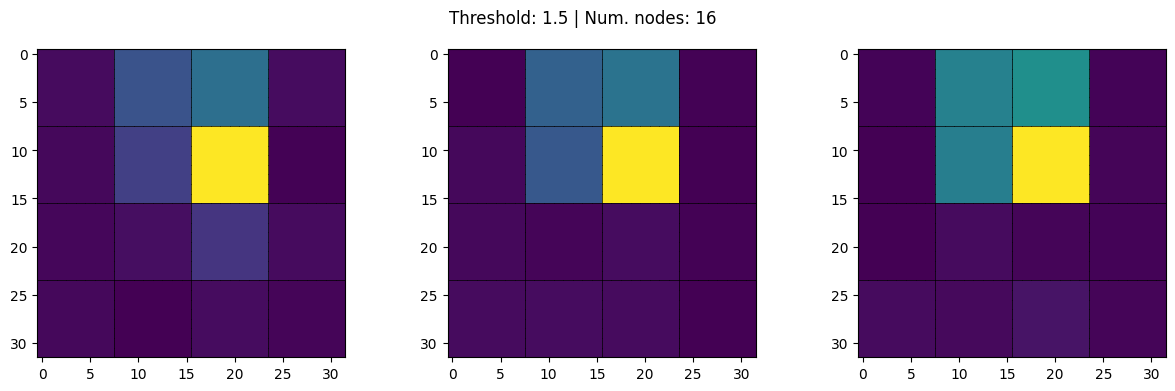

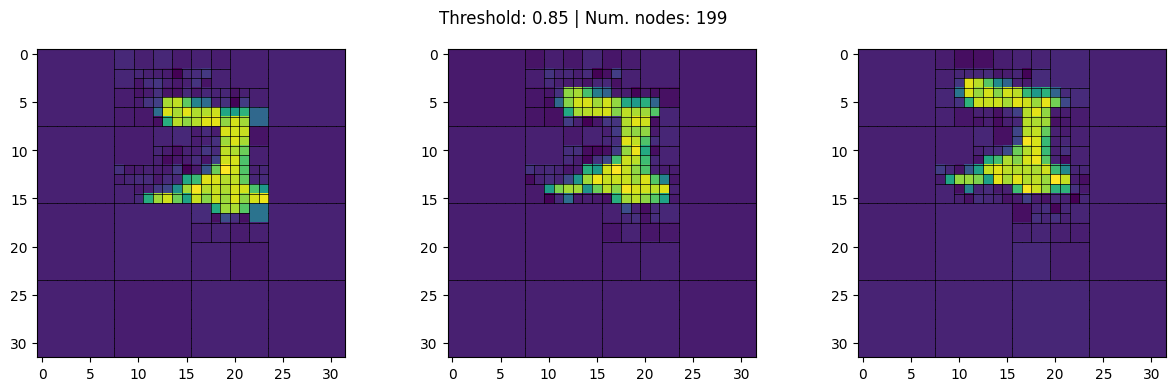

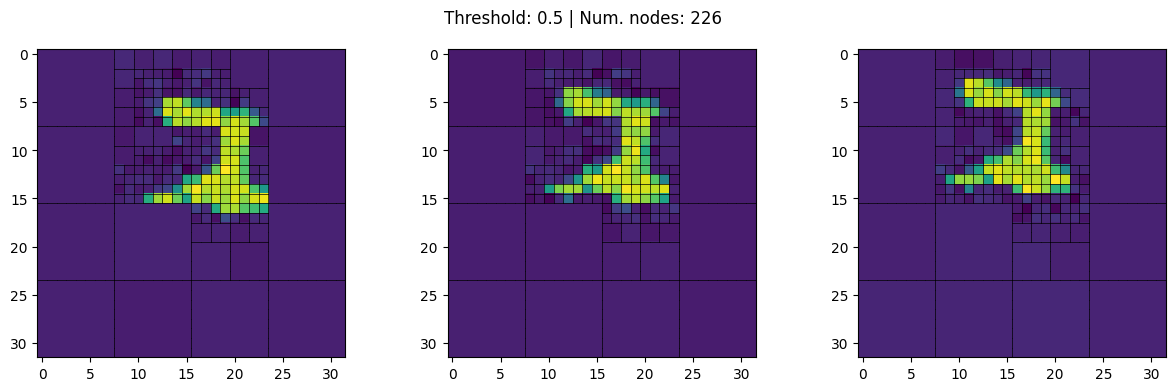

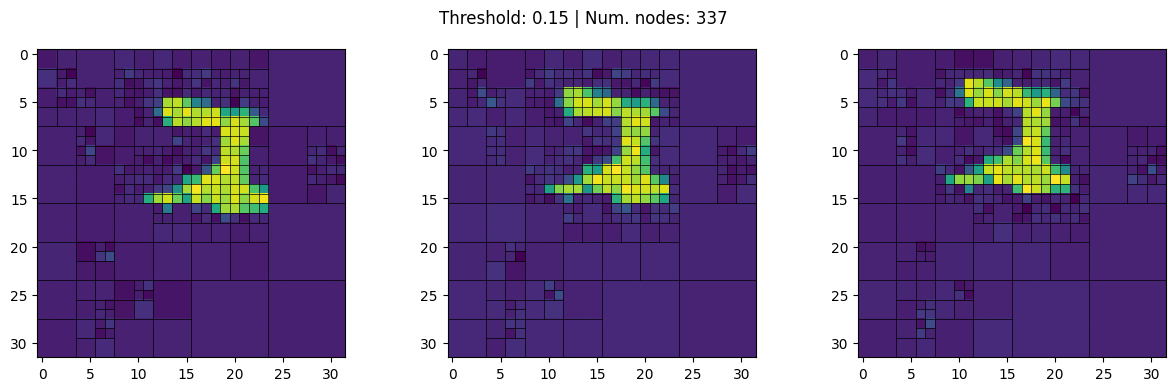

In [5]:
x, _ = next(iter(loader_val))
x = x.squeeze(0)

fig, axs = model.test_threshold(x, thresh=1.5)
plt.show()

fig, axs = model.test_threshold(x, thresh=0.85)
plt.show()

fig, axs = model.test_threshold(x, thresh=0.5)
plt.show()

fig, axs = model.test_threshold(x, thresh=0.15)
plt.show()

In [188]:
model.train(loader_train, loader_test, lr=0.01, n_epochs=20)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.11it/s]


Epoch 0 train MSE: 0.2936, test MSE: 0.3092, lr: 0.0100, time_per_epoch: 41.8


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.50it/s]


Epoch 1 train MSE: 0.2868, test MSE: 0.2809, lr: 0.0100, time_per_epoch: 42.5


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.71it/s]


Epoch 2 train MSE: 0.2841, test MSE: 0.2863, lr: 0.0095, time_per_epoch: 42.7


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.57it/s]


Epoch 3 train MSE: 0.2780, test MSE: 0.2892, lr: 0.0095, time_per_epoch: 42.7


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.60it/s]


Epoch 4 train MSE: 0.2794, test MSE: 0.2911, lr: 0.0095, time_per_epoch: 42.8


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.46it/s]


Epoch 5 train MSE: 0.2789, test MSE: 0.2742, lr: 0.0090, time_per_epoch: 42.9


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.68it/s]


Epoch 6 train MSE: 0.2740, test MSE: 0.2870, lr: 0.0090, time_per_epoch: 42.9


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch 7 train MSE: 0.2729, test MSE: 0.2715, lr: 0.0090, time_per_epoch: 42.8


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.50it/s]


Epoch 8 train MSE: 0.2613, test MSE: 0.2693, lr: 0.0086, time_per_epoch: 42.8


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.71it/s]


Epoch 9 train MSE: 0.2645, test MSE: 0.2562, lr: 0.0086, time_per_epoch: 42.7


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.80it/s]


Epoch 10 train MSE: 0.2512, test MSE: 0.2509, lr: 0.0086, time_per_epoch: 42.6


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.70it/s]


Epoch 11 train MSE: 0.2410, test MSE: 0.2411, lr: 0.0081, time_per_epoch: 42.4


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.69it/s]


Epoch 12 train MSE: 0.2445, test MSE: 0.2478, lr: 0.0081, time_per_epoch: 42.3


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.85it/s]


Epoch 13 train MSE: 0.2349, test MSE: 0.2422, lr: 0.0081, time_per_epoch: 42.2


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.85it/s]


Epoch 14 train MSE: 0.2296, test MSE: 0.2356, lr: 0.0077, time_per_epoch: 42.2


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.93it/s]


Epoch 15 train MSE: 0.2268, test MSE: 0.2475, lr: 0.0077, time_per_epoch: 42.1


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.92it/s]


Epoch 16 train MSE: 0.2323, test MSE: 0.2501, lr: 0.0077, time_per_epoch: 42.0


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.87it/s]


Epoch 17 train MSE: 0.2304, test MSE: 0.2228, lr: 0.0074, time_per_epoch: 41.9


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.68it/s]


Epoch 18 train MSE: 0.2261, test MSE: 0.2272, lr: 0.0074, time_per_epoch: 41.9


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.77it/s]

Epoch 19 train MSE: 0.2297, test MSE: 0.2347, lr: 0.0074, time_per_epoch: 41.8
Finished in 13.947781833012899 minutes


<Axes: >

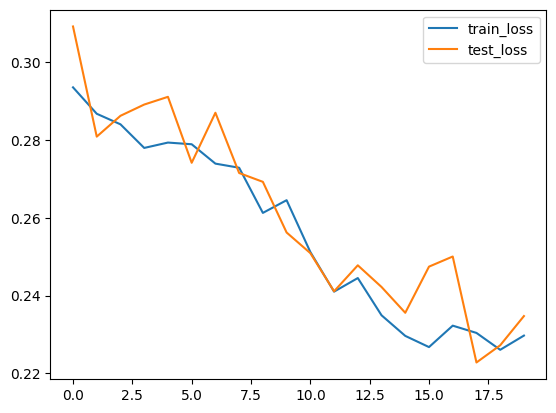

In [189]:
model.loss.plot()

In [178]:
y_hat = model.predict(loader_val)

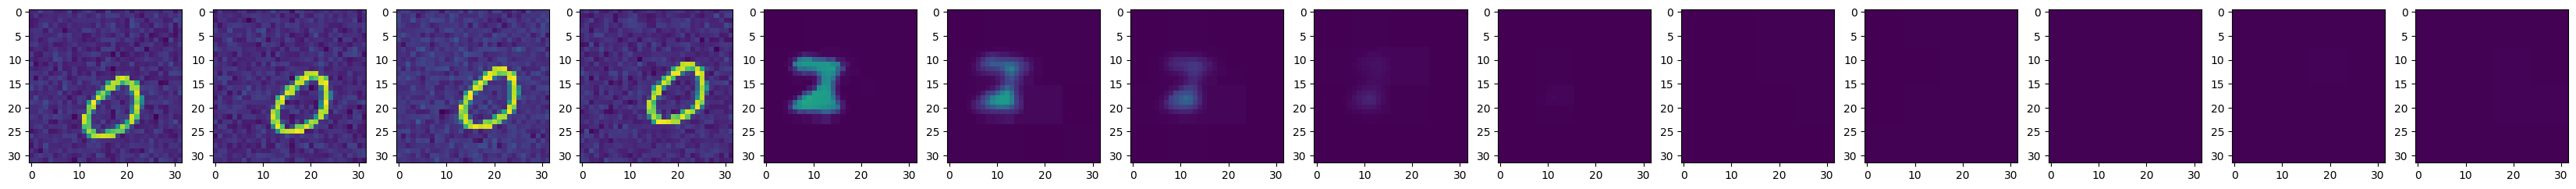

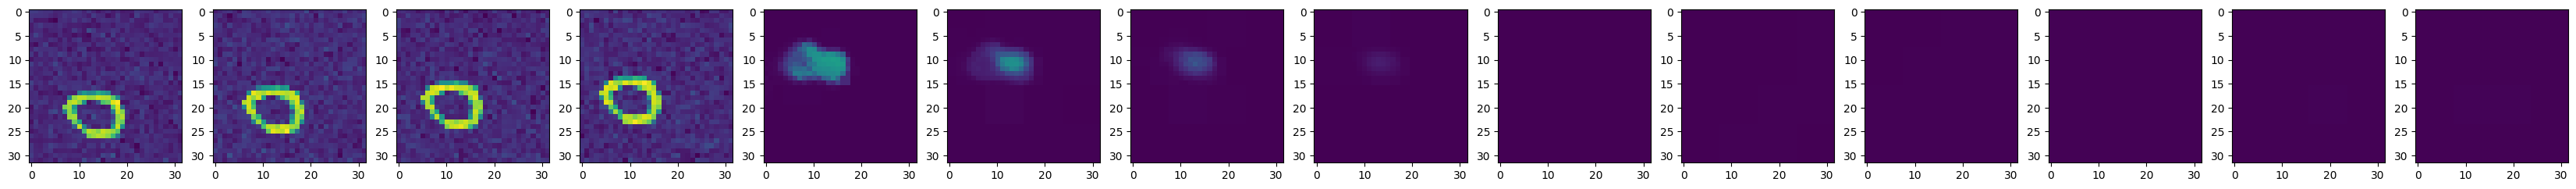

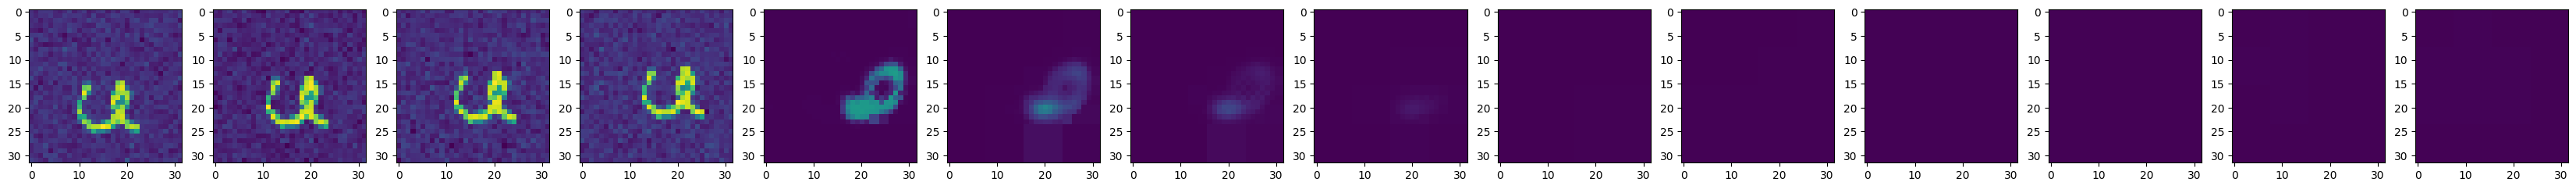

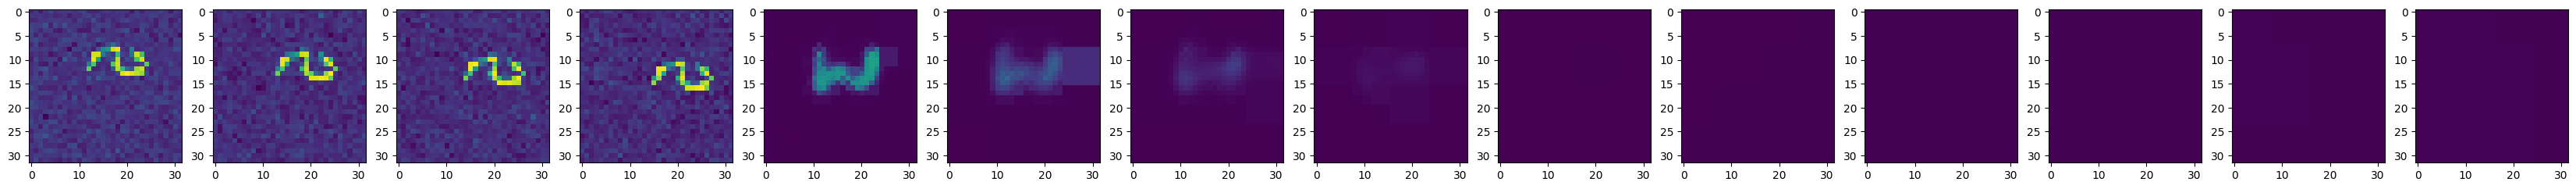

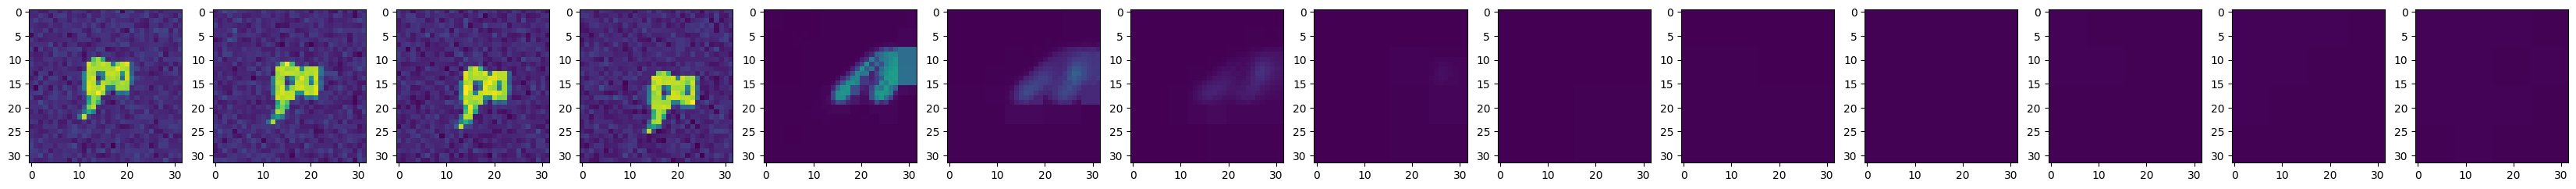

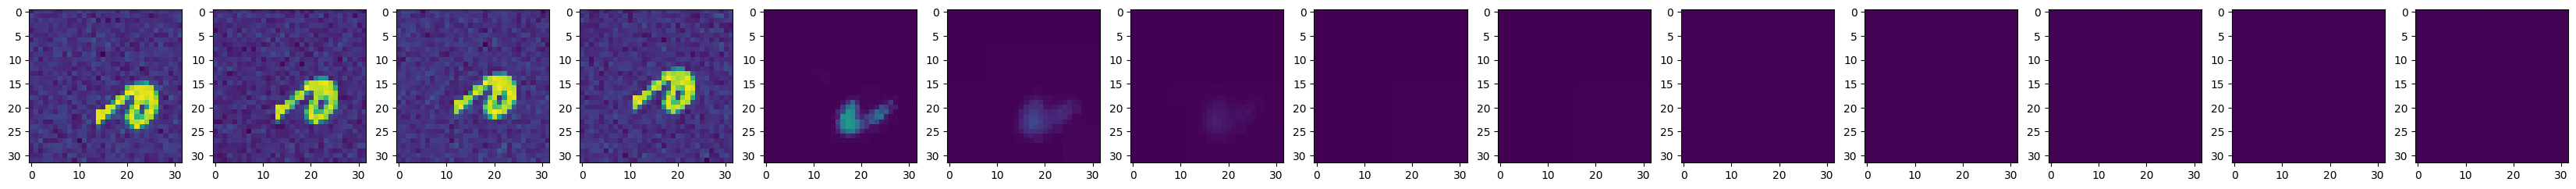

In [190]:
# Plot some example 
num_frames = 6

for i in range(num_frames):
    fig, axs = plt.subplots(1, input_timesteps+output_timesteps, figsize=(3*(input_timesteps+output_timesteps), 4))
    
    # Inputs
    for j in range(input_timesteps):
        axs[j].imshow(loader_test.dataset.x[i][j, ..., 0])
    
    for j in range(output_timesteps):
        axs[input_timesteps+j].imshow(y_hat[i][j][..., 0], vmin=0, vmax=1)  # Prediction

In [ ]:
model.loss.iloc[1:].plot()